In [1]:
#inspect_stock_data.ipynb
#
#by Joe Hahn
#jmh.datasciences@gmail.com
#23 January 2018
#
#this reads some NYSE data and makes some charts

In [2]:
#prep matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

In [3]:
#import numpy and pandas
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

In [109]:
#select date ranges, for plotting and for models
data_date_range  = ('2015-10-01', '2017-03-01')
plot_date_range  = ('2016-02-01', '2016-10-01')
model_date_range = ('2017-01-12', '2018-01-12')

In [5]:
#read NYSE data
path = 'private/eoddata/NYSE_*.zip'
drop_holidays = True
from helper_fns import *
market = read_market_data(path, start_date=data_date_range[0], end_date=data_date_range[1], 
    drop_holidays=drop_holidays)
print market.dtypes
market.head()

reading file =  private/eoddata/NYSE_2013.zip
reading file =  private/eoddata/NYSE_2014.zip
reading file =  private/eoddata/NYSE_2015.zip
reading file =  private/eoddata/NYSE_2016.zip
reading file =  private/eoddata/NYSE_2017.zip
reading file =  private/eoddata/NYSE_2018.zip
ticker            object
date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
vol                int64
dtype: object


,ticker,date,open,high,low,close,vol
1729427,A,2015-10-01,34.32,34.48,33.48,33.74,3011400
1729428,AA,2015-10-01,29.13,29.55,27.57,27.78,36864900
1729429,AAC,2015-10-01,22.27,22.69,22.11,22.59,197400
1729430,AAN,2015-10-01,36.25,36.62,35.98,36.32,597500
1729431,AAP,2015-10-01,190.28,192.64,188.10,192.04,1586900


In [8]:
#resample market timeseries data across 1-week bins
freq = 'w'
market_resampled = resample_data(market, freq)
idx = market_resampled['ticker'] == 'GE'
market_resampled[idx].tail()

,date,ticker,open,std,close,vol
196399,2017-01-30,GE,29.96,0.122240,29.70,143410200
199299,2017-02-06,GE,29.68,0.103041,29.72,124137500
202199,2017-02-13,GE,29.88,0.182346,30.37,145302400
205102,2017-02-21,GE,30.41,0.244553,30.19,116637100
208007,2017-02-27,GE,30.05,0.092511,30.19,99566500


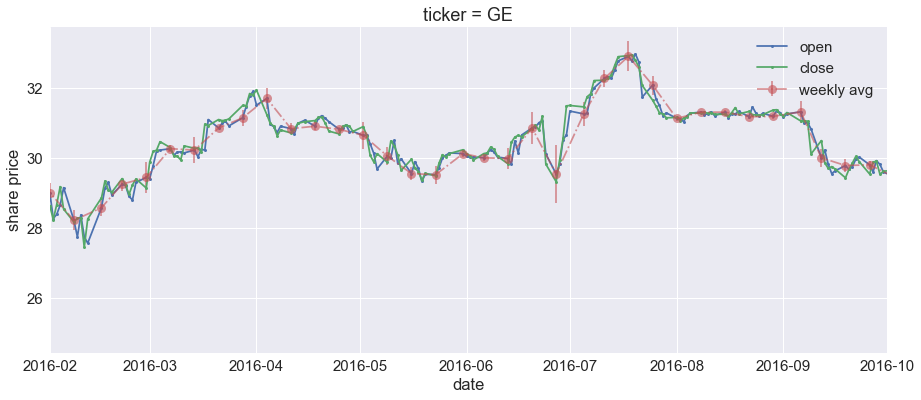

In [124]:
ticker = 'GE'
df = market
idx = (df['ticker'] == ticker)
df = df[idx].set_index('date')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
yp = df['open']
ax.plot(yp, marker='o', markersize=3, linestyle='-', label='open')
yp = df['close']
ax.plot(yp, marker='o', markersize=3, linestyle='-', label='close')
df = market_resampled
idx = (df['ticker'] == ticker)
df = df[idx].set_index('date')
yp = df['open']
xp = yp.index
err = df['std']
ax.errorbar(xp, yp, yerr=err, marker='o', markersize=9, linestyle='-.', alpha=0.6, label='weekly avg')
ax.set_title('ticker = ' + ticker)
ax.set_ylabel('share price')
ax.set_xlabel('date')
ax.set_xlim(plot_date_range)
ax.legend()
#plt.savefig('figs/field_parameters.png')

In [ ]:
#compute volume of shares traded each day
daily_volume = market.groupby('date')['vol'].sum()
daily_volume.head(10)

In [ ]:
#plot daily volume vs date
fig, ax = plt.subplots(figsize=(16, 6))
xp = daily_volume.index
yp = daily_volume.values/1.0e9
p = ax.plot(xp, yp, linestyle='-')
ax.set_title('NYSE daily share volume')
ax.set_xlabel('date')
ax.set_ylabel('shares traded    (G)')
ax.set_ylim(0, 8)
ax.set_xlim(plot_date_range)
plt.savefig('figs/volume.png')

In [ ]:
#compute volume-weighted share price versus date
def volume_weighted_share_price(record):
    vwsp = None
    cv = record['close']*record['vol']
    v_total = record['vol'].sum()
    if (v_total > 0.0):
        vwsp = cv.sum()/v_total
    return vwsp
vwsp = market.groupby('date').apply(volume_weighted_share_price)

In [ ]:
#plot volume-weighted share price vs date
fig, ax = plt.subplots(figsize=(16, 6))
xp = vwsp.index
yp = vwsp.values
p = ax.plot(xp, yp, linestyle='-')
ax.set_title('NYSE volume-weighted mean share price')
ax.set_xlabel('date')
ax.set_ylabel('volume-weighted share price')
ax.set_ylim(31, 45)
ax.set_xlim(plot_date_range)
plt.savefig('figs/vwsp.png')

In [ ]:
#plot fractional volume-weighted gain vs date
fig, ax = plt.subplots(figsize=(16, 6))
xp = vwsp.index
yp = vwsp.values
yp = (yp - yp[0])/yp[0]
p = ax.plot(xp, yp, linestyle='-')
p = ax.set_title('fractional change in NYSE volume-weighted mean share price')
p = ax.set_xlabel('date')
p = ax.set_ylabel('fractional gain')
p = ax.set_xlim(plot_date_range)
plt.savefig('figs/fractional_vwsp.png')

In [ ]:
#simulate mean outcome for 25 people, each trading $10K worth of randomly selected tickers daily
N_buyers = 25
N_tickers = 5
initial_dollars = 10000.0
idx = (market['date'] >= model_date_range[0]) & (market['date'] <= model_date_range[1])
market_data = market[idx]
ran_purchases = random_purchases(market_data, N_buyers, N_tickers, initial_dollars)

In [ ]:
#plot mean fractional gain exhibited by random purchasers
fig, ax = plt.subplots(figsize=(16, 6))
xp = ran_purchases.index.values
yp = ran_purchases['dollars_mean'].values
err = ran_purchases['dollars_std'].values/yp[0]
yp = (yp -yp[0])/yp[0]
p = ax.plot(xp, yp, linestyle='-')
p = ax.errorbar(xp, yp, err, linestyle='none', alpha=0.5)
ax.set_title('simulated outcome for daily random purchases')
ax.set_xlabel('date')
ax.set_ylabel('fractional gain')
ax.set_xlim(model_date_range)
plt.savefig('figs/random_purchases.png')